In [ ]:
%env OMP_NUM_THREADS = 4

env: OMP_NUM_THREADS=4


In [ ]:
import numpy as np # помним что "np" и т.п. -- это сокращённые навания, которые мы дали этим пакетам для удобства
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

!ls


drive  example.txt  sample_data


In [ ]:


#path = "/drive/My\ Drive/data/train.csv"
df = pd.read_csv('/content/drive/My Drive/data/train.csv')
#file_path = glob.glob
# path  = "C:\\Users\\A.OVCHINNIKOV\\02 CSV data -- STC(A)_numerical dates.csv"

#df = pd.read_csv(path, header = 0) #, encoding = "ISO-8859-1")

df.head() # Показать "шапку" -- первые 5 рядов данных

,id,name1,name2,name3,name4,name5,name6,name7,name8,name9,name10,name11,name12,name13,name14,name15,name16,name17,name18,name19,name20,name21,name22,name23,name24,name25,name26,name27,name28,name29,name30,name31,name32,name33,name34,name35,name36,name37,name38,name39,name40,name41,name42,name43,name44,name45,name46,name47,name48,predict
0,0,1,8,0,1,1.0,0,1,0.000,0,NaN,1,0,1,0,0,1,1,0,0,45.47,0.00,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,512.0,0.00,0.500000,0,0,0,1,0
1,1,0,15,0,1,1.0,0,2,0.296,1,180.000,1,10,1,0,0,1,0,0,0,14.27,0.00,0,0,0,0,1,0,9.0,4.0,0.00,0.0,0.0,0.00,1274.0,1,0,0,0,6,15,0,2859.0,0.94,0.052632,0,0,1,1,1
2,2,0,18,6,1,1.0,0,1,0.000,0,NaN,1,0,1,0,0,1,0,0,0,5.31,0.00,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,2,0,2862.0,0.92,0.049180,0,0,0,1,1
3,3,0,12,4,1,1.0,1,1,0.000,0,NaN,1,10,1,0,0,1,0,0,0,2.87,0.00,0,1,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,4,63,0,954.0,0.80,0.269360,0,0,1,1,1
4,4,1,15,4,1,1.0,0,2,95.357,1,359.996,1,0,1,2,0,1,1,0,0,35.90,18.44,0,0,0,0,8,0,2.0,4.0,0.99,2.0,0.0,13.29,2290.0,1,0,0,0,1,0,0,0.0,0.00,1.000000,0,0,0,1,0


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335036 entries, 0 to 335035
Data columns (total 50 columns):
id         335036 non-null int64
name1      335036 non-null int64
name2      335036 non-null int64
name3      335036 non-null int64
name4      335036 non-null int64
name5      335036 non-null float64
name6      335036 non-null int64
name7      335036 non-null int64
name8      335036 non-null float64
name9      335036 non-null int64
name10     208859 non-null float64
name11     335036 non-null int64
name12     335036 non-null int64
name13     335036 non-null int64
name14     335036 non-null int64
name15     335036 non-null int64
name16     335036 non-null int64
name17     335036 non-null int64
name18     335036 non-null int64
name19     335036 non-null int64
name20     335036 non-null float64
name21     335036 non-null float64
name22     335036 non-null int64
name23     335036 non-null int64
name24     335036 non-null int64
name25     335036 non-null int64
name26     335036 non

In [ ]:
df['name48'].value_counts()

1    313705
2     11940
4      4855
3      3898
5       638
Name: name48, dtype: int64

In [ ]:
# "Чистим" данные -- часть 1: меняем типы данных, которые должны быть категориальными на category

df['name48'] = df['name48'].astype('category')
df['name3'] = df['name3'].astype('category')
df['name2'] = df['name2'].astype('category')


df.info() # смотрим на результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335036 entries, 0 to 335035
Data columns (total 50 columns):
id         335036 non-null int64
name1      335036 non-null int64
name2      335036 non-null category
name3      335036 non-null category
name4      335036 non-null int64
name5      335036 non-null float64
name6      335036 non-null int64
name7      335036 non-null int64
name8      335036 non-null float64
name9      335036 non-null int64
name10     208859 non-null float64
name11     335036 non-null int64
name12     335036 non-null int64
name13     335036 non-null int64
name14     335036 non-null int64
name15     335036 non-null int64
name16     335036 non-null int64
name17     335036 non-null int64
name18     335036 non-null int64
name19     335036 non-null int64
name20     335036 non-null float64
name21     335036 non-null float64
name22     335036 non-null int64
name23     335036 non-null int64
name24     335036 non-null int64
name25     335036 non-null int64
name26     3350

In [ ]:
# "Чистим" данные -- часть 2: объединяем редкие текстовые значения ("уровни" в категориях)

df['name2'].value_counts() # для примера, посмотрим на колонку Штат (Group.State)

# это код, чтобы просмотреть на все текстовые и категориальные колонки
# for col in df.select_dtypes(include=['category','object','bool']).columns:
#    print(col)
#    print(df[col].value_counts())
#    print('\n') 

12    20144
2     18291
13    18287
3     18158
17    17703
16    17497
11    17490
15    16931
14    16928
18    16820
4     16267
10    15287
5     15141
8     15093
9     15007
6     14814
7     14672
19    12339
20     8752
1      7053
21     6762
0      6084
22     5428
23     4088
Name: name2, dtype: int64

In [ ]:
# "Чистим" данные -- часть 2: объединяем редкие текстовые значения ("уровни" в категориях)

df['name12'].value_counts() # для примера, посмотрим на колонку Штат (Group.State)

# это код, чтобы просмотреть на все текстовые и категориальные колонки
# for col in df.select_dtypes(include=['category','object','bool']).columns:
#    print(col)
#    print(df[col].value_counts())
#    print('\n') 

0     205051
7      73088
10     49158
4       3053
13      1847
14       923
5        694
9        680
2        416
23        74
24        31
1         17
18         3
28         1
Name: name12, dtype: int64

In [ ]:
# "Чистим" данные -- часть 3: обрабатываем пропущенные данные

pd.DataFrame(df).isna().sum() # Проверим, есть ли у нас пропущенные данные -- да, есть и много

id              0
name1           0
name2           0
name3           0
name4           0
name5           0
name6           0
name7           0
name8           0
name9           0
name10     126177
name11          0
name12          0
name13          0
name14          0
name15          0
name16          0
name17          0
name18          0
name19          0
name20          0
name21          0
name22          0
name23          0
name24          0
name25          0
name26          0
name27          0
name28     106506
name29     106506
name30     106506
name31     106506
name32     106506
name33     106506
name34     125756
name35          0
name36          0
name37          0
name38          0
name39          0
name40          0
name41          0
name42          0
name43          0
name44          0
name45          0
name46          0
name47          0
name48          0
predict         0
dtype: int64

In [ ]:
# Категориальные
imputer = SimpleImputer(missing_values = np.nan, strategy='constant')
imputer.fit(df.select_dtypes(exclude=['int64','float64']))
df[df.select_dtypes(exclude=['int64','float64']).columns] = imputer.transform(df.select_dtypes(exclude=['int64','float64']))
           
# Численные 
imputer = SimpleImputer(missing_values = np.nan, strategy='median')
imputer.fit(df.select_dtypes(include=['int64','float64']))
df[df.select_dtypes(include=['int64','float64']).columns] = imputer.transform(df.select_dtypes(include=['int64','float64']))
pd.DataFrame(df).isna().sum()

id         0
name1      0
name2      0
name3      0
name4      0
name5      0
name6      0
name7      0
name8      0
name9      0
name10     0
name11     0
name12     0
name13     0
name14     0
name15     0
name16     0
name17     0
name18     0
name19     0
name20     0
name21     0
name22     0
name23     0
name24     0
name25     0
name26     0
name27     0
name28     0
name29     0
name30     0
name31     0
name32     0
name33     0
name34     0
name35     0
name36     0
name37     0
name38     0
name39     0
name40     0
name41     0
name42     0
name43     0
name44     0
name45     0
name46     0
name47     0
name48     0
predict    0
dtype: int64

In [ ]:
df = pd.get_dummies(df, columns = df.select_dtypes(exclude=['int64','float64']).columns, drop_first = True)

pd.options.display.max_columns = None # снимает макс. количество колонок для просмотра; иначе видно только 20

df.head()  # получилось 252 колонки(!)

,id,name1,name2,name3,name4,name5,name6,name7,name8,name9,name10,name11,name12,name13,name14,name15,name16,name17,name18,name19,name20,name21,name22,name23,name24,name25,name26,name27,name28,name29,name30,name31,name32,name33,name34,name35,name36,name37,name38,name39,name40,name41,name42,name43,name44,name45,name46,name47,name48,predict
0,0.0,1.0,8.0,0.0,1.0,1.0,0.0,1.0,0.000,0.0,0.000,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,45.47,0.00,0.0,0.0,0.0,0.0,1.0,0.0,9.0,4.0,0.00,0.0,0.0,0.00,146.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,512.0,0.00,0.500000,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,15.0,0.0,1.0,1.0,0.0,2.0,0.296,1.0,180.000,1.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,14.27,0.00,0.0,0.0,0.0,0.0,1.0,0.0,9.0,4.0,0.00,0.0,0.0,0.00,1274.0,1.0,0.0,0.0,0.0,6.0,15.0,0.0,2859.0,0.94,0.052632,0.0,0.0,1.0,1.0,1.0
2,2.0,0.0,18.0,6.0,1.0,1.0,0.0,1.0,0.000,0.0,0.000,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.31,0.00,0.0,0.0,0.0,0.0,1.0,0.0,9.0,4.0,0.00,0.0,0.0,0.00,146.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2862.0,0.92,0.049180,0.0,0.0,0.0,1.0,1.0
3,3.0,0.0,12.0,4.0,1.0,1.0,1.0,1.0,0.000,0.0,0.000,1.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.87,0.00,0.0,1.0,0.0,0.0,1.0,0.0,9.0,4.0,0.00,0.0,0.0,0.00,146.0,0.0,0.0,0.0,0.0,4.0,63.0,0.0,954.0,0.80,0.269360,0.0,0.0,1.0,1.0,1.0
4,4.0,1.0,15.0,4.0,1.0,1.0,0.0,2.0,95.357,1.0,359.996,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,35.90,18.44,0.0,0.0,0.0,0.0,8.0,0.0,2.0,4.0,0.99,2.0,0.0,13.29,2290.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,1.000000,0.0,0.0,0.0,1.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335036 entries, 0 to 335035
Data columns (total 50 columns):
id         335036 non-null float64
name1      335036 non-null float64
name2      335036 non-null float64
name3      335036 non-null float64
name4      335036 non-null float64
name5      335036 non-null float64
name6      335036 non-null float64
name7      335036 non-null float64
name8      335036 non-null float64
name9      335036 non-null float64
name10     335036 non-null float64
name11     335036 non-null float64
name12     335036 non-null float64
name13     335036 non-null float64
name14     335036 non-null float64
name15     335036 non-null float64
name16     335036 non-null float64
name17     335036 non-null float64
name18     335036 non-null float64
name19     335036 non-null float64
name20     335036 non-null float64
name21     335036 non-null float64
name22     335036 non-null float64
name23     335036 non-null float64
name24     335036 non-null float64
name25     335

In [ ]:
y = df['predict']
X = df.drop(columns = 'predict')

In [ ]:
# На первом вебинаре мы разбили данные по номеру. Это неидеально и может привести к систематическим ошибкам, например, если данные отсортированы каким-либо образом
# Более правильный подход -- случайное разбиение

# Для этого укажем стартовое значение ("семя" / "seed") для генератора случайных чисел
np.random.seed(77300)

# разобъем в пропорции 80% обучающая (train) / 20% тестовая (test) 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, stratify=y)
# Важно: разбивка стратифицирована (stratify), пропорция удержанных и неудржанных клиентов одинакова в обоих подвыборках

# смотрим на результат
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(268028, 49)
(67008, 49)
(268028,)
(67008,)


In [ ]:
# Для начала определим несколько "рабочих" функций для построения метрик модели

# кривая ROC
def plot_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate = False)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='Кривая ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel('1-Специфичность (ложно отрицательный процент)')
    plt.ylabel('Чувствительность (истино положительный процент)')
    plt.title('Кривая ROC')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# для чувствительности
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# для специфичности
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# для прогностической ценности положительного результата
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# для прогностической ценности отрицательного результата
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# для точности
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

In [ ]:
# определяем модель логистической регрессии и называем её classifier_LR
classifier_LR = LogisticRegression()

# обучаем модель classifier_LR на обучающей выборке
classifier_LR.fit(X_train, y_train)

# Коэффициенты переменных 
print('Константа: ' + str(classifier_LR.intercept_))
print('Коэффициенты (10 самых больших и 10 самых маленьких): ')
summary = pd.DataFrame([X_test.columns,classifier_LR.coef_[0]]).transpose().sort_values(by = 1, ascending = False)
summary.columns = ['Переменная','Коэффициент']
top10positive = summary.head(10) # Показываем 10 самых больших (по значению)
top10negative = summary.tail(10) # Показываем 10 самых маленьких (по значению)
top10list=pd.DataFrame()
top10list= top10list.append(pd.DataFrame(data = top10positive))
top10list= top10list.append(pd.DataFrame(data = top10negative))
top10list


Константа: [0.00047893]
Коэффициенты (10 самых больших и 10 самых маленьких): 


,Переменная,Коэффициент
28,name28,0.00415192
2,name2,0.00251888
26,name26,0.00229798
7,name7,0.00227194
29,name29,0.00167584
3,name3,0.00135296
10,name10,0.00121143
12,name12,0.00111439
9,name9,0.000620984
16,name16,0.000598675


In [ ]:
# получаем предсказания модели для тестовой выборки

y_pred_prob = classifier_LR.predict_proba(X_test)[:,1] # вероятности

# Критическое (пороговое) значение -- будем использовать Т=0.6073. Почему? Почему не 50%? 60,73% -- это средняя вероятность удержания клиента в наших данных (1451 "1" из 2389 наблюдений) 
class_threshold = 0.6073

y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # классификация

print(y_pred_prob[0:5]) # распечатаем полученные вероятности (первые 5)
print(y_pred[0:5]) # распечатаем полученную классификацию (первые 5)
print(y_test[0:5]) # распечатаем реальные исходы (первые 5)

# опа... на первых 5-и клиентах наша модель сделала две ошибки (на 1-м и 3-м клиентах)

[0.81226464 0.84189812 0.84924366 0.85466197 0.76773891]
[1 1 1 1 1]
84614     0.0
129199    1.0
222353    1.0
179112    1.0
249086    0.0
Name: predict, dtype: float64


Метрики модели логистической регрессии: 

Матрица ошибок: 
[[  804  2377]
 [ 9379 54448]]
                                               Точность: 0.8245582617000955
                 Чувствительность (SENSITIVITY, RECALL): 0.9581698196216454
                  Специфичность (SPECIFICITY, FALL-OUT): 0.07895512128056564
 Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): 0.8530559167750326
   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): 0.25275070732474064


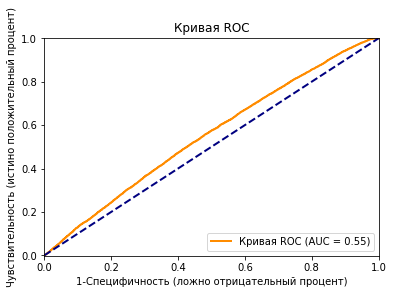

 AUC: 0.551952416402362


In [ ]:
# Посмотрим на метрики модели 
print('Метрики модели логистической регрессии: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Матрица ошибок: \n" + str(cm))

print("                                               Точность: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                 Чувствительность (SENSITIVITY, RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                  Специфичность (SPECIFICITY, FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


In [ ]:
!pip install shap

In [ ]:
#import shap
#shap.initjs()
#не для лин регрессии

#explainer = shap.TreeExplainer(classifier_LR)
#shap_values = explainer.shap_values(X)
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [ ]:
# исключение "ненужных" переменных методом пошаговой "обратной регрессии" (Stepwise Recursive Feature Selection)

from sklearn.feature_selection import RFE

rfe = RFE(estimator=classifier_LR, n_features_to_select=10, step=1) # в этом примере мы отбираем 10 переменных
rfe.fit(X_train, y_train)
ranking = rfe.ranking_.reshape(len(X_train.columns))

# какие 10 переменных включены в модель?
pd.DataFrame([X_test.columns,ranking]).transpose().sort_values(1).head(20)

,0,1
17,name17,1
1,name1,1
22,name22,1
18,name18,1
4,name4,1
5,name5,1
16,name16,1
44,name44,1
14,name14,1
9,name9,1


Метрики модели логистической регрессии после исключения "ненужных" переменных: 

Матрица ошибок: 
[[ 3628  1818]
 [ 6555 55007]]
                                               Точность: 0.875044770773639
                 Чувствительность (SENSITIVITY, RECALL): 0.9680070391553014
                  Специфичность (SPECIFICITY, FALL-OUT): 0.35628007463419425
 Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): 0.8935219778434749
   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): 0.6661770106500183


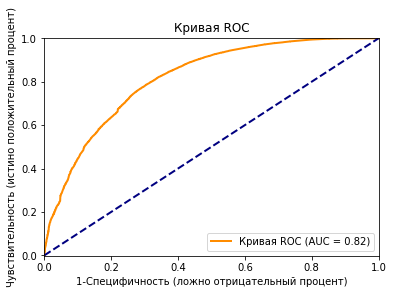

 AUC: 0.8152036526116719


In [ ]:
# обучаем модель classifier_LR_RFE на всей обучающей выборке
classifier_LR_RFE = rfe.fit(X_train, y_train)

# получаем предсказания модели для тестовой выборки
y_pred_prob = classifier_LR_RFE.predict_proba(X_test)[:,1] # вероятности
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # классификация


# Посмотрим на метрики модели после исключения "ненужных" переменных 
print('Метрики модели логистической регрессии после исключения "ненужных" переменных: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Матрица ошибок: \n" + str(cm))

print("                                               Точность: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                 Чувствительность (SENSITIVITY, RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                  Специфичность (SPECIFICITY, FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


In [ ]:
# определяем модель деревьев и называем её classifier_DT
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 5, random_state=77300) # random_state -- это параметр генератора случайных чисел, нужный для того, чтобы каждый раз получать один и тот же результат

# обучаем модель classifier_DT на обучающей выборке
classifier_DT.fit(X_train, y_train)

# получаем предсказания модели для тестовой выборки
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1] # вероятнсти 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # классификация

print(y_pred_prob[0:5]) # распечатаем полученные вероятности (первые 5)
print(y_pred[0:5]) # распечатаем полученную классификацию (первые 5)
print(y_test[0:5]) # распечатаем реальные исходы (первые 5)

# ух ты! на первых 5-и клиентах наша модель не сделала ни одной ошибки!

[0.95446325 0.64170486 0.64170486 0.84391342 0.84391342]
[1 1 1 1 1]
84614     0.0
129199    1.0
222353    1.0
179112    1.0
249086    0.0
Name: predict, dtype: float64


Дерево решений с 5-ю листьями


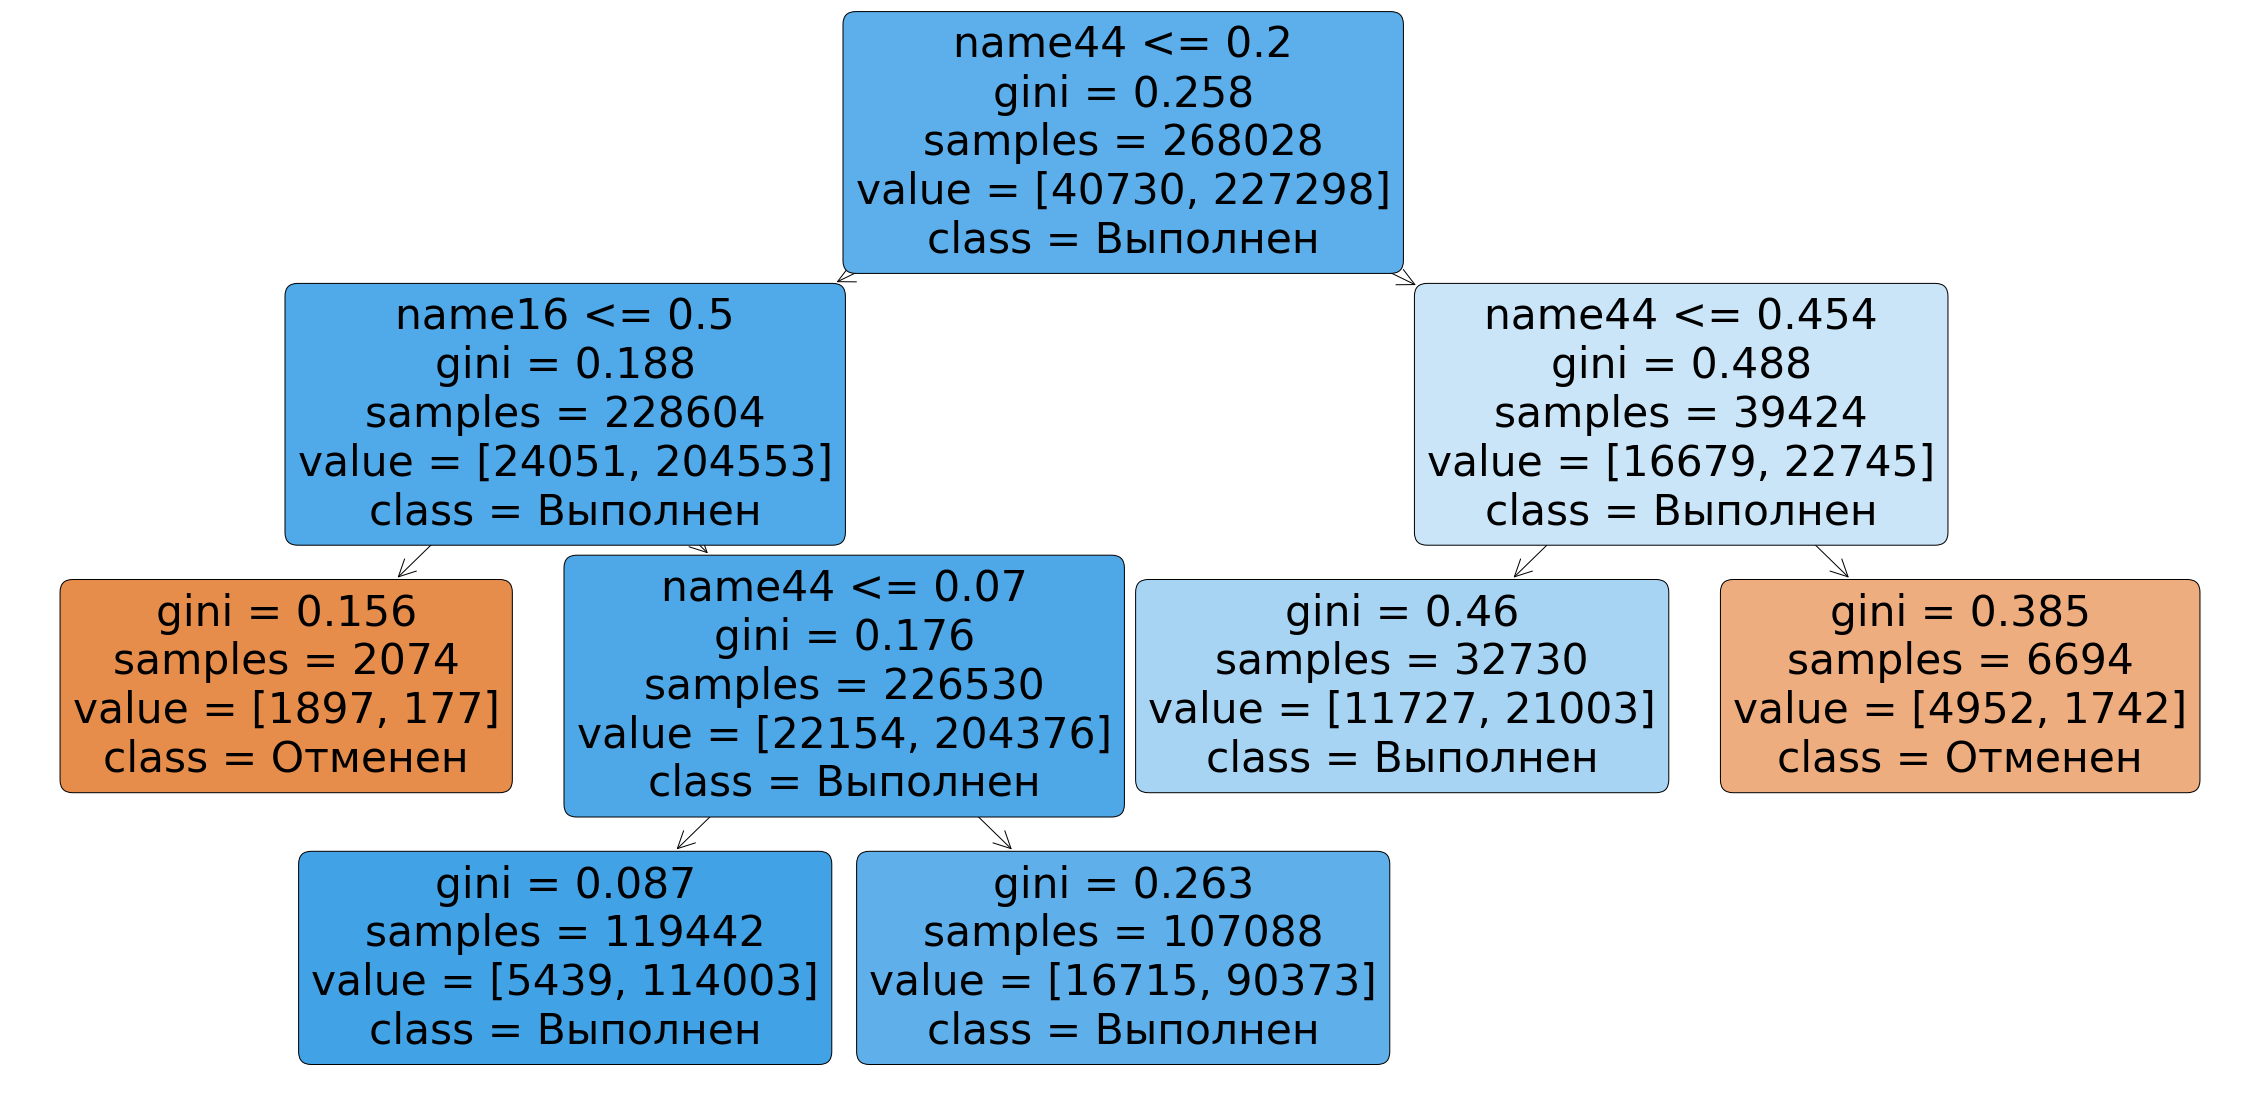

In [ ]:
# визуализируем полученное дерево

from sklearn import tree

plt.figure(figsize=(40,20))
tree.plot_tree(classifier_DT.fit(X_train, y_train), feature_names = X_train.columns, filled = True, 
               class_names = ['Отменен', 'Выполнен'], rounded = True)
print('Дерево решений с 5-ю листьями')

Метрики модели деревьев принятия решений: 

Матрица ошибок: 
[[ 1747   477]
 [ 8436 56348]]
                                               Точность: 0.8669860315186246
                 Чувствительность (SENSITIVITY, RECALL): 0.9916058073031236
                  Специфичность (SPECIFICITY, FALL-OUT): 0.17156044387705
 Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): 0.8697826623857743
   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): 0.7855215827338129


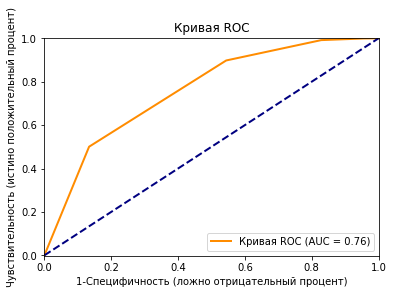

 AUC: 0.759954551893918


In [ ]:
# Посмотрим на метрики модели
print('Метрики модели деревьев принятия решений: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Матрица ошибок: \n" + str(cm))

print("                                               Точность: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                 Чувствительность (SENSITIVITY, RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                  Специфичность (SPECIFICITY, FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))



In [ ]:
import sklearn
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='macro')


0.6041614722201121

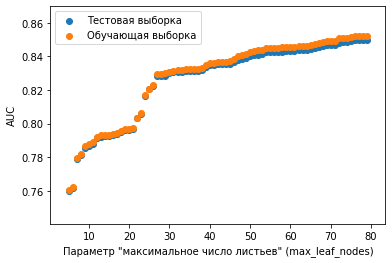

In [ ]:
# Подбор гипер-параметра "максимальное число листьев" (max_leaf_nodes)

n_max_leaf_nodes = range(5,40) # просчитаем модели с 5, 6, 7, ... 40 листьев

# сначала считаем AUC для тестовой выборки 
array = []
for n in n_max_leaf_nodes:
    
    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)
    
    y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]   
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_test, y_pred_prob)])

# график для тестовой
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# затем считаем AUC для обучающей выборки 
array = []
for n in n_max_leaf_nodes:

    classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = n)
    classifier_DT = classifier_DT.fit(X_train, y_train)
    
    y_pred_prob = classifier_DT.predict_proba(X_train)[:,1] 
    y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

    array.append([n,roc_auc_score(y_train, y_pred_prob)])

# график для обучающей
array = pd.DataFrame(array)
plt.scatter(array[0],array[1])

# подписываем оси
plt.xlabel('Параметр "максимальное число листьев" (max_leaf_nodes)')
plt.ylabel('AUC')

# добавляем легенду
plt.legend(['Тестовая выборка','Обучающая выборка'])


In [ ]:
# Обучим модель с 25-ю листьями
classifier_DT = tree.DecisionTreeClassifier(criterion = 'gini', max_leaf_nodes = 0)
classifier_DT = classifier_DT.fit(X_train, y_train)

# получим её предсказания
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]   
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

# посчитаем и распечатаем AUC
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))
f1_score(y_test, y_pred, average='macro')


 AUC: 0.8502585034389805


0.751789796283271

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.67      0.50      0.57     10183
         1.0       0.91      0.96      0.93     56825

    accuracy                           0.89     67008
   macro avg       0.79      0.73      0.75     67008
weighted avg       0.88      0.89      0.88     67008



In [ ]:
# определяем модель случайного леса и называем её classifier_RF
classifier_RF = RandomForestClassifier(random_state=77300) # random_state -- это параметр генератора случайных чисел, нужный для того, чтобы каждый раз получать один и тот же результат

# обучаем модель classifier_RF на обучающей выборке
classifier_RF.fit(X_train, y_train)

# У модели случайного леса несколько гипер-параметров, например:
# -- количество деревьев в ансамбле, 
# -- правила голосования в ансамбле, 
# -- макс. количество листьев на каждом дереве, 
# -- мин. количество наблюдений (точек данных) на листе кадого дерева
# и т.п.

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=77300,
                       verbose=0, warm_start=False)

Метрики модели случайного леса: 

Матрица ошибок: 
[[ 5388  2104]
 [ 4795 54721]]
                                               Точность: 0.8970421442215855
                 Чувствительность (SENSITIVITY, RECALL): 0.9629740431148263
                  Специфичность (SPECIFICITY, FALL-OUT): 0.5291171560443877
 Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): 0.9194334296659722
   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): 0.7191671115856914


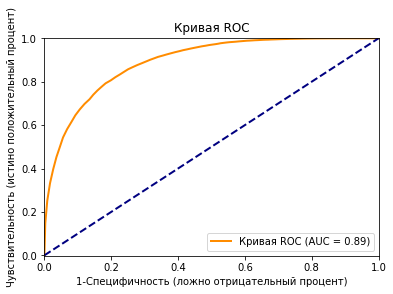

 AUC: 0.8919266106018765
 f1_score: 0.77518743241819


In [ ]:
# получаем предсказания модели для тестовой выборки
y_pred_prob = classifier_RF.predict_proba(X_test)[:,1] # вероятности 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # классификация

# смотрим на метрики модели
print('Метрики модели случайного леса: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Матрица ошибок: \n" + str(cm))

print("                                               Точность: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                 Чувствительность (SENSITIVITY, RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                  Специфичность (SPECIFICITY, FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))
print(" f1_score: " + str(f1_score(y_test, y_pred, average='macro')))


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.53      0.61     10183
         1.0       0.92      0.96      0.94     56825

    accuracy                           0.90     67008
   macro avg       0.82      0.75      0.78     67008
weighted avg       0.89      0.90      0.89     67008



Подобранные (оптимизированные) гипер-параметры:{'n_estimators': 10}
Метрики модели случайного леса с подобранным (оптимизированным) гипер-параметром "количество деревьев": 

Матрица ошибок: 
[[ 5952  4169]
 [ 4231 52656]]
                                               Точность: 0.8746418338108882
                 Чувствительность (SENSITIVITY, RECALL): 0.9266344038715354
                  Специфичность (SPECIFICITY, FALL-OUT): 0.5845035844053815
 Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): 0.9256244836254329
   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): 0.5880841814049995


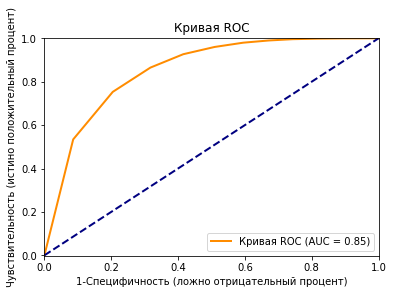

 AUC: 0.8530496403281453


In [ ]:
# подбор ("оптимизация") гипер-параметров при помощи функции GridSearchCV для максимизации AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

n_trees = [10, 100, 500] # будем подбирать гипер-параметр "количество деревьев", и просчитаем модели с 10, 100 и 500 деревьев "в лесу"
Grid_srch_parameters_list = [ [{'n_estimators':n_trees}] ] 

# качество модели оценим через 5-кратную кросс-валидацию. Наилучшая модель будет сохранена под именем grid_search
grid_search = GridSearchCV(estimator = classifier_RF, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# обучим модель grid_search на всей обучающей выборке
grid_search_RF = grid_search.fit(X_train, y_train)

# предскажем тестовую выборку при помощи обученной модели 
y_pred_prob = grid_search_RF.predict_proba(X_test)[:,1]   
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

print('Подобранные (оптимизированные) гипер-параметры:' + str(grid_search.best_params_))
    
# смотрим на метрики модели
print('Метрики модели случайного леса с подобранным (оптимизированным) гипер-параметром "количество деревьев": \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Матрица ошибок: \n" + str(cm))

print("                                               Точность: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                 Чувствительность (SENSITIVITY, RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                  Специфичность (SPECIFICITY, FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)

print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


In [ ]:
print(" f1_score: " + str(f1_score(y_test, y_pred, average='macro')))

 f1_score: 0.7562087922505731


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.59      0.58      0.59     10183
         1.0       0.93      0.93      0.93     56825

    accuracy                           0.87     67008
   macro avg       0.76      0.76      0.76     67008
weighted avg       0.87      0.87      0.87     67008



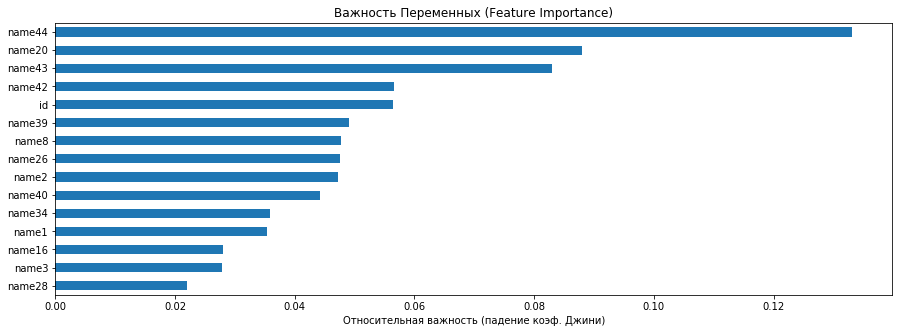

In [ ]:
# В моделях на базе деревьев нет "коэфициентов"
# Более того, в моделях-ансамблях (таких как случайный лес) нет большого смысла смотреть на индивидуальные деревья

# Полезную интуицию можно получить из графика Важности Переменных (Feature Importance Plot)

# считаем "важности"
importances = classifier_RF.feature_importances_ 

# строим график
plt.figure(figsize=(15,5))
plt.title('Важность Переменных (Feature Importance)')
plt.xlabel('Относительная важность (падение коэф. Джини)')
feature_importances = pd.Series(classifier_RF.feature_importances_, index=X_train.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', align='center')

In [ ]:
# определяем модель градиентного бустинга и называем её classifier_GBM
classifier_GBM = GradientBoostingClassifier(random_state=77300)

# обучаем модель classifier_GBM на обучающей выборке
classifier_GBM.fit(X_train, y_train)

# У модели градиентного бустинга несколько гипер-параметров, например:
# -- количество деревьев в ансамбле, 
# -- скорость "бустинга" (обучения), 
# -- макс. количество листьев на каждом дереве, 
# -- мин. количество наблюдений (точек данных) на листе кадого дерева
# и т.п.


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=77300, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Метрики модели градиентного бустинга: 

Матрица ошибок: 
[[ 4888  1842]
 [ 5295 54983]]
                                               Точность: 0.893490329512894
                 Чувствительность (SENSITIVITY, RECALL): 0.9675846898372196
                  Специфичность (SPECIFICITY, FALL-OUT): 0.4800157124619464
 Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): 0.9121570058727894
   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): 0.7263001485884101


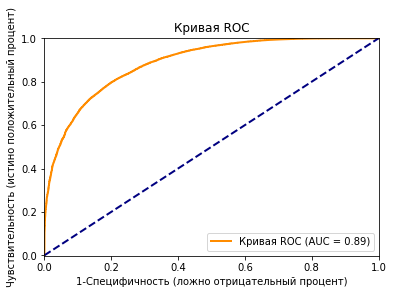

 AUC: 0.8876136106522957
 f1_score: 0.7585352818451745
              precision    recall  f1-score   support

         0.0       0.73      0.48      0.58     10183
         1.0       0.91      0.97      0.94     56825

    accuracy                           0.89     67008
   macro avg       0.82      0.72      0.76     67008
weighted avg       0.88      0.89      0.88     67008



In [ ]:
# получаем предсказания модели для тестовой выборки
y_pred_prob = classifier_GBM.predict_proba(X_test)[:,1] # вероятности 
y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # классификация

# смотрим на метрики модели
print('Метрики модели градиентного бустинга: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Матрица ошибок: \n" + str(cm))

print("                                               Точность: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                 Чувствительность (SENSITIVITY, RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                  Специфичность (SPECIFICITY, FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)
print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))
print(" f1_score: " + str(f1_score(y_test, y_pred, average='macro')))
print(classification_report(y_test, y_pred))

Подобранные (оптимизированные) гипер-параметры:{'learning_rate': 0.1, 'n_estimators': 500}
Метрики модели градиентого бустинга с подобранными (оптимизированными) гипер-параметрами: 

Матрица ошибок: 
[[ 5447  2119]
 [ 4736 54706]]
                                               Точность: 0.897698782234957
                 Чувствительность (SENSITIVITY, RECALL): 0.9627100747910251
                  Специфичность (SPECIFICITY, FALL-OUT): 0.5349111263871158
 Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): 0.9203256956360822
   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): 0.7199312714776632


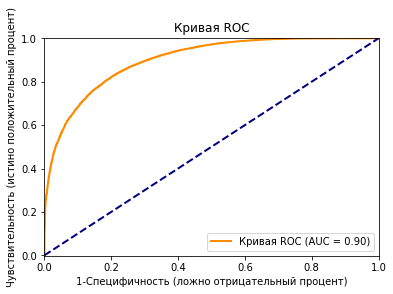

 AUC: 0.8998355548802277


In [ ]:
# подбор ("оптимизация") гипер-параметров при помощи функции GridSearchCV для максимизации AUC
score_func = make_scorer(roc_auc_score, greater_is_better=True)

# будем подбирать два гипер-параметра 
n_trees = [10, 100, 500] # "количество деревьев" в ансамбле; просчитаем 10, 100 и 500 
learning_rates = [0.01, 0.1] # и скорось "бустинга" (обучения); для каждого кол-ва деревьев почситаем для двух скоростей 0.01 и 0.1
Grid_srch_parameters_list = [ [{'n_estimators':n_trees, 'learning_rate': learning_rates}] ] 

# качество модели оценим через 5-кратную кросс-валидацию. Наилучая модель будет сохранена под именем grid_search
grid_search = GridSearchCV(estimator = classifier_GBM, cv = 5, param_grid = Grid_srch_parameters_list[0], scoring = score_func,
                              return_train_score = True) 

# обучим модель grid_search на всей обучающей выборке
grid_search_GBM = grid_search.fit(X_train, y_train)

# предскажем тестовую выборку при помощи обученной модели 
y_pred_prob = grid_search_GBM.predict_proba(X_test)[:,1]
y_pred = np.where(y_pred_prob > class_threshold, 1, 0)

print('Подобранные (оптимизированные) гипер-параметры:' + str(grid_search.best_params_))

# смотрим на метрики модели
print('Метрики модели градиентого бустинга с подобранными (оптимизированными) гипер-параметрами: \n')

cm = np.transpose(confusion_matrix(y_test, y_pred))
print("Матрица ошибок: \n" + str(cm))

print("                                               Точность: " + str(custom_accuracy_score(y_test, y_pred))) 
print("                 Чувствительность (SENSITIVITY, RECALL): " + str(custom_sensitivity_score(y_test, y_pred)))
print("                  Специфичность (SPECIFICITY, FALL-OUT): " + str(custom_specificity_score(y_test, y_pred)))
print(" Прогн. ценн. полож. рез. (POS. PRED. VALUE, PRECISION): " + str(custom_ppv_score(y_test, y_pred)))
print("   Прогн. ценн. отриц. рез. (NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, y_pred)))

plot_roc(y_test, y_pred_prob)

print(" AUC: " + str(roc_auc_score(y_test, y_pred_prob)))


In [ ]:
print(" f1_score: " + str(f1_score(y_test, y_pred, average='macro')))
print(classification_report(y_test, y_pred))

 f1_score: 0.777410969065564
              precision    recall  f1-score   support

         0.0       0.72      0.53      0.61     10183
         1.0       0.92      0.96      0.94     56825

    accuracy                           0.90     67008
   macro avg       0.82      0.75      0.78     67008
weighted avg       0.89      0.90      0.89     67008



In [ ]:
ff = pd.read_csv('/content/drive/My Drive/data/test.csv')

In [ ]:
ff.head()


,id,name1,name2,name3,name4,name5,name6,name7,name8,name9,name10,name11,name12,name13,name14,name15,name16,name17,name18,name19,name20,name21,name22,name23,name24,name25,name26,name27,name28,name29,name30,name31,name32,name33,name34,name35,name36,name37,name38,name39,name40,name41,name42,name43,name44,name45,name46,name47,name48
0,0,1,14,2,0,1.05,0,2,99.267,1,539.996,1,7,1,0,0,1,0,0,0,6.67,0.0,0,0,0,0,1,0,12.0,4.0,0.00,0.0,0.0,0.43,3251.0,1,0,0,0,0,3,0,7.0,0.43,0.500000,0,0,1,1
1,1,0,14,2,1,1.00,0,3,181.460,1,0.000,1,7,1,0,0,1,0,0,0,11.87,0.0,0,1,0,0,1,0,19.0,3.0,0.98,5.0,0.0,3.64,91.0,1,0,0,0,1,6,0,1205.0,0.96,0.039192,1,0,1,1
2,2,1,12,2,0,1.00,0,2,2042.170,1,1320.000,8,0,1,1,1,1,1,0,0,9.00,0.0,1,0,0,0,8,0,5.0,6.0,0.97,2.0,0.0,0.87,5027.0,1,0,0,0,0,1,0,3058.0,0.95,0.031056,0,0,0,1
3,3,0,17,2,1,1.05,0,3,217.973,1,0.000,1,7,1,0,0,1,0,0,0,6.43,0.0,0,0,0,0,1,0,8.0,5.0,0.98,1.0,1.0,4.95,25.0,1,0,0,0,2,6,0,3808.0,0.94,0.048611,1,0,1,1
4,4,0,8,2,0,1.00,0,3,479.606,1,0.000,1,10,1,0,0,1,1,0,0,11.27,0.0,0,0,0,0,1,0,29.0,2.0,0.00,0.0,0.0,10.00,32.0,1,0,0,0,10,17,0,3519.0,0.91,0.067616,1,0,1,1


In [ ]:
ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29139 entries, 0 to 29138
Data columns (total 49 columns):
id        29139 non-null int64
name1     29139 non-null int64
name2     29139 non-null int64
name3     29139 non-null int64
name4     29139 non-null int64
name5     29139 non-null float64
name6     29139 non-null int64
name7     29139 non-null int64
name8     29139 non-null float64
name9     29139 non-null int64
name10    19472 non-null float64
name11    29139 non-null int64
name12    29139 non-null int64
name13    29139 non-null int64
name14    29139 non-null int64
name15    29139 non-null int64
name16    29139 non-null int64
name17    29139 non-null int64
name18    29139 non-null int64
name19    29139 non-null int64
name20    29139 non-null float64
name21    29139 non-null float64
name22    29139 non-null int64
name23    29139 non-null int64
name24    29139 non-null int64
name25    29139 non-null int64
name26    29139 non-null int64
name27    29139 non-null int64
name28    208

In [ ]:
null_value_stats = ff.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

name10    9667
name28    8264
name29    8264
name30    8264
name31    8264
name32    8264
name33    8264
name34    7766
dtype: int64

In [ ]:
# Численные 
imputer = SimpleImputer(missing_values = np.nan, strategy='median')
imputer.fit(ff.select_dtypes(include=['int64','float64']))
ff[ff.select_dtypes(include=['int64','float64']).columns] = imputer.transform(ff.select_dtypes(include=['int64','float64']))

In [ ]:
null_value_stats = ff.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

In [ ]:

 
# Например, возьмём случайный лес и используем уже обученную модель с подобранными гипер-параметрами, вспомним: она называется grid_search_RF
y_pred_prob = grid_search_GBM.predict_proba(ff)[:,1]

# добавим колонку ID, чтобы знать "кто есть кто"
Prediction = pd.DataFrame(data={"id":test_data["id"],"predict":y_pred_prob}) 

# экспортируем предсказанные вероятности в CSV файл
Prediction.to_csv("Submission.csv",sep = ',')



In [ ]:
# получаем предсказания модели для тестовой выборки

y_pred_prob = grid_search_GBM.predict_proba(ff)[:,1] # вероятности

# Критическое (пороговое) значение -- будем использовать Т=0.6073. Почему? Почему не 50%? 60,73% -- это средняя вероятность удержания клиента в наших данных (1451 "1" из 2389 наблюдений) 
class_threshold = 0.6073

y_pred = np.where(y_pred_prob > class_threshold, 1, 0) # классификация
# добавим колонку ID, чтобы знать "кто есть кто"
Prediction = pd.DataFrame(data={"id":ff["id"],"predict":y_pred}) 

Prediction.head()


,id,predict
0,0.0,0
1,1.0,1
2,2.0,1
3,3.0,1
4,4.0,1


In [ ]:

Prediction['id'] = Prediction['id'].astype('int')
Prediction.head()

,id,predict
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [ ]:
# экспортируем предсказанные вероятности в CSV файл
Prediction.to_csv("Submission2.csv",sep = ',')